[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)

# Practical 1: More dogs and cats!

This time, you are going to use the [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) by [O. M. Parkhi et al., 2012](http://www.robots.ox.ac.uk/~vgg/publications/2012/parkhi12a/parkhi12a.pdf) which features 12 cat breeds and 25 dogs breeds. You will need to adapt the code from lesson 1 to this new task, i.e. a classification with 37 categories.

##  Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torchvision
from torchvision import models,transforms,datasets
import time
%matplotlib inline

In [ ]:
torch.__version__

'1.13.1+cu116'

In [ ]:
import sys
sys.version

'3.8.10 (default, Nov 14 2022, 12:59:47) \n[GCC 9.4.0]'

Check if GPU is available and if not change the [runtime](https://jovianlin.io/pytorch-with-gpu-in-google-colab/).

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


## Downloading the data

The data given on the website [Oxford-IIIT Pet Dataset](http://www.robots.ox.ac.uk/~vgg/data/pets/) is made of two files: `images.tar.gz` and `annotations.tar.gz`. We first need to download and decompress these files.

Depending if you use google colab or your own computer, you can adapt the code below to choose where to store the data.

To see where you are, you can use the standard unix comands:

In [ ]:
%pwd

'/content'

If you want to change to a directory to store your data:

In [ ]:
%cd /content

/content


In [ ]:
%pwd

'/content'

In [ ]:
%mkdir data
# the line below needs to be adapted if not running on google colab 
%cd ./data/

/content/data


Now that you are in the right directory, you can download the data:

In [ ]:
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
!wget https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz

--2023-01-21 09:05:08--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz’

images.tar.gz       100%[===================>] 755.23M  14.2MB/s    in 55s     

2023-01-21 09:06:04 (13.7 MB/s) - ‘images.tar.gz’ saved [791918971/791918971]

--2023-01-21 09:06:04--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  7.58MB/s    in 2.4s    

2023-01-21 

and uncompress it:

In [ ]:
!tar zxvf images.tar.gz
!tar zxvf annotations.tar.gz

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

Check that everything went correctly!

In [ ]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz


## Warning

If you are running this notebook on your own computer, you need to download the data only once. If you want to run this notebook a second time, you can safely skip this section and the section below as your dataset will be stored nicely on your computer.

If you are running this notebook on google colab, you need to download the data and to do the data wrangling each time you are running this notebook as data will be cleared once you log off.

## 1. Exercise: data wrangling

You will first need to do a bit of [data wrangling](https://en.wikipedia.org/wiki/Data_wrangling) to organize your dataset in order to use the PyTorch `dataloader`.

If you want to understand how the files are organized, have a look at the `README` file in the folder `annotations`.

First, we need to split the dataset in a test set and train/validation set. For this, we can use the files `annotations/test.txt` and `annotations/trainval.txt` containing the names of images contained in the test and train/validation sets of the original paper.

In [ ]:
!head annotations/test.txt

Abyssinian_201 1 1 1
Abyssinian_202 1 1 1
Abyssinian_204 1 1 1
Abyssinian_205 1 1 1
Abyssinian_206 1 1 1
Abyssinian_207 1 1 1
Abyssinian_20 1 1 1
Abyssinian_210 1 1 1
Abyssinian_212 1 1 1
Abyssinian_213 1 1 1


In [ ]:
!head annotations/trainval.txt

Abyssinian_100 1 1 1
Abyssinian_101 1 1 1
Abyssinian_102 1 1 1
Abyssinian_103 1 1 1
Abyssinian_104 1 1 1
Abyssinian_105 1 1 1
Abyssinian_106 1 1 1
Abyssinian_107 1 1 1
Abyssinian_108 1 1 1
Abyssinian_109 1 1 1


Above you see that the authors of the original paper made a partition of the dataset: `./images/Abyssinian_201.jpg` is in the test set while `./images/Abyssinian_100.jpg` is in the train/validation set and so on.

BTW, it you wonder what Abyssinian means, it is explained [here](https://en.wikipedia.org/wiki/Abyssinian_cat)

We first create two directories where we will put images form the test and trainval sets.

In [ ]:
%mkdir test
%mkdir trainval

In [ ]:
%ls

annotations/  annotations.tar.gz  images/  images.tar.gz  test/  trainval/


Now it's your turn!

All the images are in the `./images/` folder and you want to store the data according to the following structure:
```bash
.
├── test
|   └── Abyssinian # contains images of Abyssinian from the test set
|   └── Bengal # contains images of Bengal from the test set
|    ... 
|   └── american_bulldog # contains images of american bulldog from the test set
|    ...
├── trainval
|   └── Abyssinian # contains images of Abyssinian from the trainval set
|   └── Bengal # contains images of Bengal from the trainval set
|    ...
|   └── american_bulldog # contains images of american bulldog from the trainval set
|    ...
```

Note that all images wiht a name starting with a majuscule is a cat and all images with a name starting with a minuscule is a dog.

So here is one way to achieve your task: you will read the `./annotations/test.txt` file line by line; from each line, you will extract the name of the corresponding file and then copy it from the `./images/filename_##.jpg` to `./test/filename/filename_##.jpg`, where `##` is a number.

Then you'll do the same thing for `trainval.txt` file.

Below is a little piece of code to show you how to open a file and read it line by line:

In [ ]:
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        print(f)
        line = fp.readline()
        break

Abyssinian_201


In order to remove the `_201` in the example above, you can use the `re` [regular expression lib](https://docs.python.org/3.6/library/re.html) as follows:

In [ ]:
import re
pat = re.compile(r'_\d')
res,_ = pat.split(f)
print(res)
! pwd

Abyssinian
/content/data


This small piece of code might be useful:

In [ ]:
# create directory if it does not exist
def check_dir(dir_path):
    dir_path = dir_path.replace('//','/')
    os.makedirs(dir_path, exist_ok=True)

Some more hints:
- for moving files around you can use the `shutil` lib, see [here](https://docs.python.org/3.6/library/shutil.html#shutil.copy)
- you can use `os.path.join`
- have a look at python [f-string](https://cito.github.io/blog/f-strings/)

In [ ]:
import shutil

In [ ]:
# Here your code for test
with open('./annotations/test.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        pat = re.compile(r'_\d')
        res,_ = pat.split(f)
        check_dir(f'./test/{res}/')
        shutil.move(f'./images/{f}.jpg', f'./test/{res}/{f}.jpg')
        line = fp.readline()

In [ ]:
# Here your code for train
with open('./annotations/trainval.txt') as fp:
    line = fp.readline()
    while line:
        f,_,_,_ = line.split(' ')
        pat = re.compile(r'_\d')
        res,_ = pat.split(f)
        check_dir(f'./trainval/{res}/')
        shutil.move(f'./images/{f}.jpg', f'./trainval/{res}/{f}.jpg')
        line = fp.readline()

## Data processing

In [ ]:
%cd ..

/content


Now you are ready to redo what we did during lesson 1.

Below, you give the path where the data is stored. If you are running this code on your computer, you should modifiy this cell.

In [ ]:
data_dir = '/content/data/'

`datasets` is a class of the `torchvision` package (see [torchvision.datasets](http://pytorch.org/docs/master/torchvision/datasets.html)) and deals with data loading. It integrates a multi-threaded loader that fetches images from the disk, groups them in mini-batches and serves them continously to the GPU right after each _forward_/_backward_ pass through the network.

Images needs a bit of preparation before passing them throught the network. They need to have all the same size $224\times 224 \times 3$ plus some extra formatting done below by the normalize transform (explained later).

In [ ]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

vgg_format = transforms.Compose([
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize,
            ])

In [ ]:
dsets = {x: datasets.ImageFolder(os.path.join(data_dir, x), vgg_format)
         for x in ['trainval', 'test']}

In [ ]:
os.path.join(data_dir,'trainval')

'/content/data/trainval'

We now have 37 different classes.

In [ ]:
dsets['trainval'].classes

['Abyssinian',
 'Bengal',
 'Birman',
 'Bombay',
 'British_Shorthair',
 'Egyptian_Mau',
 'Maine_Coon',
 'Persian',
 'Ragdoll',
 'Russian_Blue',
 'Siamese',
 'Sphynx',
 'american_bulldog',
 'american_pit_bull_terrier',
 'basset_hound',
 'beagle',
 'boxer',
 'chihuahua',
 'english_cocker_spaniel',
 'english_setter',
 'german_shorthaired',
 'great_pyrenees',
 'havanese',
 'japanese_chin',
 'keeshond',
 'leonberger',
 'miniature_pinscher',
 'newfoundland',
 'pomeranian',
 'pug',
 'saint_bernard',
 'samoyed',
 'scottish_terrier',
 'shiba_inu',
 'staffordshire_bull_terrier',
 'wheaten_terrier',
 'yorkshire_terrier']

In [ ]:
dsets['trainval'].class_to_idx

{'Abyssinian': 0,
 'Bengal': 1,
 'Birman': 2,
 'Bombay': 3,
 'British_Shorthair': 4,
 'Egyptian_Mau': 5,
 'Maine_Coon': 6,
 'Persian': 7,
 'Ragdoll': 8,
 'Russian_Blue': 9,
 'Siamese': 10,
 'Sphynx': 11,
 'american_bulldog': 12,
 'american_pit_bull_terrier': 13,
 'basset_hound': 14,
 'beagle': 15,
 'boxer': 16,
 'chihuahua': 17,
 'english_cocker_spaniel': 18,
 'english_setter': 19,
 'german_shorthaired': 20,
 'great_pyrenees': 21,
 'havanese': 22,
 'japanese_chin': 23,
 'keeshond': 24,
 'leonberger': 25,
 'miniature_pinscher': 26,
 'newfoundland': 27,
 'pomeranian': 28,
 'pug': 29,
 'saint_bernard': 30,
 'samoyed': 31,
 'scottish_terrier': 32,
 'shiba_inu': 33,
 'staffordshire_bull_terrier': 34,
 'wheaten_terrier': 35,
 'yorkshire_terrier': 36}

In [ ]:
dset_sizes = {x: len(dsets[x]) for x in ['trainval', 'test']}
dset_sizes

{'trainval': 3680, 'test': 3669}

In [ ]:
dset_classes = dsets['trainval'].classes

The `torchvision` packages allows complex pre-processing/transforms of the input data (_e.g._ normalization, cropping, flipping, jittering). A sequence of transforms can be grouped in a pipeline with the help of the `torchvision.transforms.Compose` function, see [torchvision.transforms](http://pytorch.org/docs/master/torchvision/transforms.html)

In [ ]:
loader_train = torch.utils.data.DataLoader(dsets['trainval'], shuffle=True, batch_size=64, num_workers=6)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
loader_valid = torch.utils.data.DataLoader(dsets['test'], shuffle=False, batch_size=5, num_workers=6)

Check your dataloader and everything is doing fine

In [ ]:
count = 1
for data in loader_valid:
    print(count, end=',')
    if count == 1:
        inputs_try,labels_try = data
    count += 1

1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,

In [ ]:
labels_try

tensor([0, 0, 0, 0, 0])

In [ ]:
inputs_try.shape

torch.Size([5, 3, 224, 224])

A small function to display images:

In [ ]:
def imshow(inp, title=None):
#   Imshow for Tensor.
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip(std * inp + mean, 0,1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

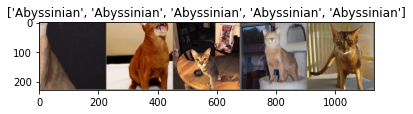

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs_try)

imshow(out, title=[dset_classes[x] for x in labels_try])

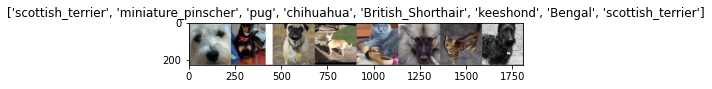

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(loader_train))

n_images = 8

# Make a grid from batch
out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

## 2. Exercise: modifying VGG Model

The torchvision module comes with a zoo of popular CNN architectures which are already trained on [ImageNet](http://www.image-net.org/) (1.2M training images). When called the first time, if `pretrained=True` the model is fetched over the internet and downloaded to `~/.torch/models`.
For next calls, the model will be directly read from there.

In [ ]:
model_vgg = models.vgg16(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

In [ ]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)

model_vgg = model_vgg.to(device)

In [ ]:
outputs_try = model_vgg(inputs_try)

In [ ]:
outputs_try

tensor([[-1.0556, -4.2370, -0.8440,  ..., -0.0239, -1.4763,  1.4541],
        [-2.8068, -3.2894, -3.9324,  ..., -1.9060,  0.4222,  4.3091],
        [-0.2091,  0.9227, -2.1281,  ..., -2.6601,  1.7060,  3.6279],
        [ 3.1060, -0.4312,  0.6417,  ..., -3.1860,  1.7189,  0.5556],
        [-0.4096, -0.3154, -3.7863,  ..., -5.0919,  3.3732, -0.3411]],
       device='cuda:0', grad_fn=<AddmmBackward0>)

In [ ]:
outputs_try.shape

torch.Size([5, 1000])

### Modifying the last layer and setting the gradient false to all layers

In [ ]:
print(model_vgg)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

We'll learn about what these different blocks do later in the course. For now, it's enough to know that:

- Convolution layers are for finding small to medium size patterns in images -- analyzing the images locally
- Dense (fully connected) layers are for combining patterns across an image -- analyzing the images globally
- Pooling layers downsample -- in order to reduce image size and to improve invariance of learned features

![vgg16](https://dataflowr.github.io/notebooks/Module1/img/vgg16.png)

Here, our goal is to use the already trained model and just change the number of output classes. To this end we replace the last ```nn.Linear``` layer trained for 1000 classes to ones with 37 classes. In order to freeze the weights of the other layers during training, we set the field ```required_grad=False```. In this manner no gradient will be computed for them during backprop and hence no update in the weights. Only the weights for the 37-class layer will be updated.

PyTorch documentation for [LogSoftmax](https://pytorch.org/docs/stable/nn.html#logsoftmax)

In [ ]:
# freezing the weigths of other layers during training
for param in model_vgg.parameters():
    param.requires_grad = False
# your code here
model_vgg.classifier._modules['6'] = nn.Linear(in_features=4096,
                                           out_features=37,
                                           bias=True)
model_vgg.classifier._modules['7'] = nn.LogSoftmax(dim=1)

In [ ]:
print(model_vgg.classifier)

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=37, bias=True)
  (7): LogSoftmax(dim=1)
)


Once you modified the architecture of the network, do not forget to put in onto the device!

In [ ]:
# your code here
model_vgg = model_vgg.to(device)

## Training fully connected module

### Creating loss function and optimizer

PyTorch documentation for [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) and the [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [ ]:
criterion = nn.NLLLoss()
lr = 0.001
optimizer_vgg = torch.optim.SGD(model_vgg.classifier[6].parameters(),lr = lr)

### Training the model

In [ ]:
def train_model(model,dataloader,size,epochs=1,optimizer=None):
    model.train()
    
    for epoch in range(epochs):
        running_loss = 0.0
        running_corrects = 0
        for inputs,classes in dataloader:
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            loss = criterion(outputs,classes)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            _,preds = torch.max(outputs.data,1)
            # statistics
            running_loss += loss.data.item()
            running_corrects += torch.sum(preds == classes.data)
        epoch_loss = running_loss / size
        epoch_acc = running_corrects.data.item() / size
        print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))

In [ ]:
%%time
train_model(model_vgg,loader_train,size=dset_sizes['trainval'],epochs=2,optimizer=optimizer_vgg)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.0519 Acc: 0.1326
Loss: 0.0386 Acc: 0.4315
CPU times: user 17.5 s, sys: 1.55 s, total: 19 s
Wall time: 42.7 s


In [ ]:
def test_model(model,dataloader,size):
    model.eval()
    predictions = np.zeros(size)
    all_classes = np.zeros(size)
    all_proba = np.zeros((size,37))
    i = 0
    running_loss = 0.0
    running_corrects = 0
    #print(size)
    for inputs,classes in dataloader:
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model(inputs)
        loss = criterion(outputs,classes)           
        _,preds = torch.max(outputs.data,1)
            # statistics
        running_loss += loss.data.item()
        running_corrects += torch.sum(preds == classes.data)
        predictions[i:i+len(classes)] = preds.to('cpu').numpy()
        all_classes[i:i+len(classes)] = classes.to('cpu').numpy()
        all_proba[i:i+len(classes),:] = outputs.data.to('cpu').numpy()
        i += len(classes)
    epoch_loss = running_loss / size
    epoch_acc = running_corrects.data.item() / size
    print('Loss: {:.4f} Acc: {:.4f}'.format(
                     epoch_loss, epoch_acc))
    return predictions, all_proba, all_classes

In [ ]:
predictions, all_proba, all_classes = test_model(model_vgg,loader_valid,size=dset_sizes['test'])

Loss: 0.4037 Acc: 0.7277


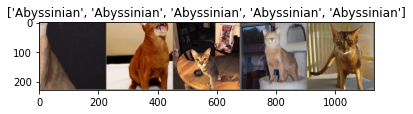

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(loader_valid))

out = torchvision.utils.make_grid(inputs[0:n_images])

imshow(out, title=[dset_classes[x] for x in classes[0:n_images]])

Compute the predictions made by your network for `inputs[:n_images]` and the associated probabilities.

Hint: use `torch.max` and `torch.exp`.

Do not forget to put your inputs on the device!

In [ ]:
# your code here
inputs_device = inputs[:n_images].to(device)
outputs = model_vgg(inputs_device)
vals_try, preds_try = outputs, torch.max(outputs.data, 1)

In [ ]:
preds_try

torch.return_types.max(
values=tensor([-3.1316, -2.6048, -2.7600, -2.7806, -2.6584], device='cuda:0'),
indices=tensor([20, 26,  5,  1,  1], device='cuda:0'))

In [ ]:
classes[:n_images]

tensor([0, 0, 0, 0, 0])

In [ ]:
torch.exp(vals_try)

tensor([[1.0396, 1.0282, 1.0193, 1.0229, 1.0441, 1.0284, 1.0267, 1.0229, 1.0162,
         1.0257, 1.0263, 1.0390, 1.0317, 1.0417, 1.0337, 1.0305, 1.0351, 1.0240,
         1.0267, 1.0226, 1.0446, 1.0202, 1.0156, 1.0178, 1.0265, 1.0216, 1.0394,
         1.0202, 1.0182, 1.0291, 1.0378, 1.0221, 1.0163, 1.0391, 1.0245, 1.0217,
         1.0146],
        [1.0514, 1.0304, 1.0300, 1.0212, 1.0373, 1.0311, 1.0190, 1.0147, 1.0167,
         1.0252, 1.0264, 1.0419, 1.0222, 1.0227, 1.0289, 1.0330, 1.0333, 1.0454,
         1.0314, 1.0126, 1.0302, 1.0165, 1.0095, 1.0355, 1.0198, 1.0232, 1.0767,
         1.0195, 1.0178, 1.0345, 1.0239, 1.0173, 1.0217, 1.0457, 1.0211, 1.0145,
         1.0140],
        [1.0590, 1.0382, 1.0335, 1.0316, 1.0303, 1.0653, 1.0332, 1.0209, 1.0283,
         1.0288, 1.0183, 1.0243, 1.0177, 1.0312, 1.0251, 1.0259, 1.0343, 1.0316,
         1.0213, 1.0209, 1.0318, 1.0126, 1.0150, 1.0127, 1.0177, 1.0202, 1.0270,
         1.0158, 1.0215, 1.0186, 1.0185, 1.0210, 1.0328, 1.0495, 1.0330, 

## Speeding up the learning by precomputing features

In [ ]:
def preconvfeat(dataloader):
    conv_features = []
    labels_list = []
    for data in dataloader:
        inputs,labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        x = model_vgg.features(inputs)
        conv_features.extend(x.data.cpu().numpy())
        labels_list.extend(labels.data.cpu().numpy())
    conv_features = np.concatenate([[feat] for feat in conv_features])
    return (conv_features,labels_list)

In [ ]:
%%time
conv_feat_train,labels_train = preconvfeat(loader_train)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


CPU times: user 8.99 s, sys: 1.39 s, total: 10.4 s
Wall time: 21.5 s


In [ ]:
conv_feat_train.shape

(3680, 512, 7, 7)

In [ ]:
%%time
conv_feat_valid,labels_valid = preconvfeat(loader_valid)

CPU times: user 19.3 s, sys: 1.74 s, total: 21.1 s
Wall time: 28.1 s


### Creating a new data generator

We will not load images anymore, so we need to build our own data loader.

In [ ]:
dtype=torch.float
datasetfeat_train = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_train,labels_train)]
datasetfeat_train = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_train]
loaderfeat_train = torch.utils.data.DataLoader(datasetfeat_train, batch_size=128, shuffle=True)

Now you can train for more epochs.

In [ ]:
%%time
train_model(model_vgg.classifier,dataloader=loaderfeat_train,size=dset_sizes['trainval'],epochs=80,optimizer=optimizer_vgg)

Loss: 0.0159 Acc: 0.5799
Loss: 0.0143 Acc: 0.6432
Loss: 0.0128 Acc: 0.6908
Loss: 0.0119 Acc: 0.7158
Loss: 0.0109 Acc: 0.7408
Loss: 0.0101 Acc: 0.7587
Loss: 0.0096 Acc: 0.7753
Loss: 0.0090 Acc: 0.7916
Loss: 0.0086 Acc: 0.7986
Loss: 0.0082 Acc: 0.8084
Loss: 0.0078 Acc: 0.8073
Loss: 0.0076 Acc: 0.8000
Loss: 0.0072 Acc: 0.8242
Loss: 0.0070 Acc: 0.8258
Loss: 0.0068 Acc: 0.8285
Loss: 0.0065 Acc: 0.8375
Loss: 0.0064 Acc: 0.8375
Loss: 0.0062 Acc: 0.8391
Loss: 0.0060 Acc: 0.8486
Loss: 0.0059 Acc: 0.8476
Loss: 0.0057 Acc: 0.8470
Loss: 0.0057 Acc: 0.8459
Loss: 0.0056 Acc: 0.8495
Loss: 0.0054 Acc: 0.8462
Loss: 0.0054 Acc: 0.8587
Loss: 0.0052 Acc: 0.8587
Loss: 0.0051 Acc: 0.8584
Loss: 0.0051 Acc: 0.8527
Loss: 0.0050 Acc: 0.8598
Loss: 0.0048 Acc: 0.8712
Loss: 0.0049 Acc: 0.8636
Loss: 0.0048 Acc: 0.8636
Loss: 0.0047 Acc: 0.8606
Loss: 0.0046 Acc: 0.8668
Loss: 0.0045 Acc: 0.8668
Loss: 0.0045 Acc: 0.8696
Loss: 0.0044 Acc: 0.8747
Loss: 0.0045 Acc: 0.8660
Loss: 0.0043 Acc: 0.8734
Loss: 0.0043 Acc: 0.8747


In [ ]:
datasetfeat_valid = [[torch.from_numpy(f).type(dtype),torch.tensor(l).type(torch.long)] for (f,l) in zip(conv_feat_valid,labels_valid)]
datasetfeat_valid = [(inputs.reshape(-1), classes) for [inputs,classes] in datasetfeat_valid]
loaderfeat_valid = torch.utils.data.DataLoader(datasetfeat_valid, batch_size=128, shuffle=False)

Now you can compute the accuracy on the test set.

In [ ]:
predictions, all_proba, all_classes = test_model(model_vgg.classifier,dataloader=loaderfeat_valid,size=dset_sizes['test'])

Loss: 0.0035 Acc: 0.8839


## Confusion matrix

For 37 classes, plotting a confusion matrix is useful to see the performance of the algorithm per class.

In [ ]:
#!pip install -U scikit-learn

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
def make_fig_cm(cm):
    fig = plt.figure(figsize=(12,12))
    plt.imshow(cm, interpolation='nearest', cmap='Blues')
    tick_marks = np.arange(37);
    plt.xticks(tick_marks, dset_classes, rotation=90);
    plt.yticks(tick_marks, dset_classes, rotation=0);
    plt.tight_layout();
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        coeff = f'{cm[i, j]}'
        plt.text(j, i, coeff, horizontalalignment="center", verticalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Actual');
    plt.xlabel('Predicted');

In [ ]:
cm = confusion_matrix(all_classes,predictions)
print(cm)

[[52 11  1 ...  0  0  0]
 [ 4 71  0 ...  0  0  0]
 [ 0  0 79 ...  0  0  0]
 ...
 [ 0  0  0 ... 52  0  0]
 [ 0  0  0 ...  1 86  0]
 [ 0  0  0 ...  0  1 87]]


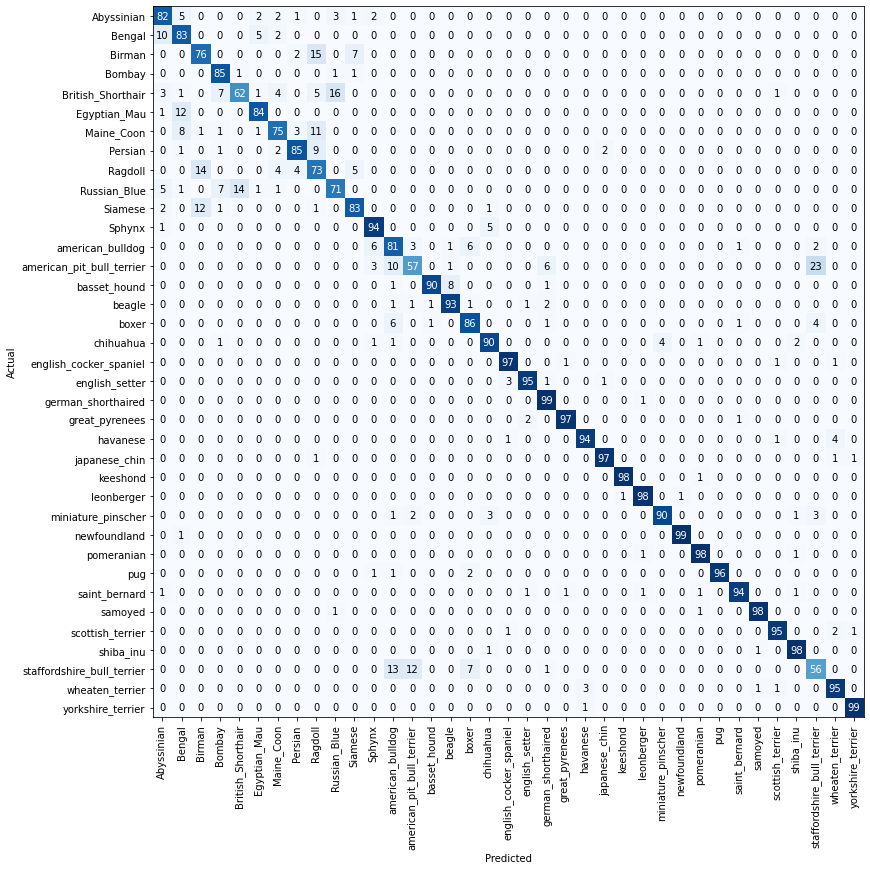

In [ ]:
make_fig_cm(cm)

Here, you see that [american pit bull terrier](https://en.wikipedia.org/wiki/American_Pit_Bull_Terrier) are often predicted as [staffordshire bull terrier](https://en.wikipedia.org/wiki/Staffordshire_Bull_Terrier) but overall your algorithm should give pretty good results!

## 3. Exercise: change of neural network model

Great! So far, you reproduced the result of the first lesson. Now, you will need to take another model. I propose to take a `resnet34` from the list availabel [here](https://pytorch.org/docs/stable/torchvision/models.html)

__Note__ the main purpose of this exercise is to lean how to modify a network. We do not really care about performances...

In [ ]:
model_resnet = models.resnet34(pretrained=True)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [ ]:
print(model_resnet)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

OK, the strucutre is quite different from the one of VGG we saw during the course but we still see that the last layer is a Linear layer taking a vector of size 512 and producing a vector of size 1000 (i.e. the number of classes in Imagenet). Hence you should be able to modify this network for your classification task with 37 classes!

First freeze the weights of your model and replace the last layer by a Linear layer with the appropriate size.

In [ ]:
print(model_resnet.fc)

Linear(in_features=512, out_features=1000, bias=True)


In [ ]:
# your code here
#Hint print(model_resnet.fc)
# freezing the weigths of other layers during training
for param in model_vgg.parameters():
    param.requires_grad = False
model_resnet.fc = nn.Linear(512, 37)

Now we need to add the LogSoftmax layer. Follow the instructions [here](https://discuss.pytorch.org/t/how-to-add-an-additional-layer-on-top-of-a-pretrained-model/21303/2) to add this layer

In [ ]:
model_resnet_lsm = nn.Sequential(model_resnet, nn.LogSoftmax(dim=1))

Check that everything is working fine!

In [ ]:
inputs_try , labels_try = inputs_try.to(device), labels_try.to(device)
model_resnet_lsm = model_resnet_lsm.to(device)
outputs_try = model_resnet_lsm(inputs_try)

In [ ]:
outputs_try.shape

torch.Size([5, 37])

Now you can start training.

You will take the same loss as before: [NLLLoss](https://pytorch.org/docs/stable/nn.html#nllloss) but you need to modify the argument of the optimizer [torch.optim module](https://pytorch.org/docs/stable/optim.html#module-torch.optim)

In [ ]:
print(model_resnet_lsm[0].fc.parameters())

<generator object Module.parameters at 0x7f2f004bedd0>


In [ ]:
#Hint print(model_resnet_lsm[0].fc)
optimizer_resnet = torch.optim.SGD(model_resnet_lsm[0].fc.parameters(), lr=lr)

Now you can use the same function as above for the training loop.

In [ ]:
%%time
train_model(model_resnet_lsm,loader_train,size=dset_sizes['trainval'],epochs=30,optimizer=optimizer_resnet)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 6 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Loss: 0.0579 Acc: 0.0394
Loss: 0.0549 Acc: 0.0840
Loss: 0.0523 Acc: 0.1427
Loss: 0.0500 Acc: 0.2190
Loss: 0.0477 Acc: 0.3014
Loss: 0.0456 Acc: 0.3698
Loss: 0.0437 Acc: 0.4293
Loss: 0.0417 Acc: 0.4867
Loss: 0.0399 Acc: 0.5451
Loss: 0.0382 Acc: 0.5842
Loss: 0.0366 Acc: 0.6174
Loss: 0.0351 Acc: 0.6576
Loss: 0.0336 Acc: 0.6715
Loss: 0.0323 Acc: 0.6935
Loss: 0.0311 Acc: 0.7149
Loss: 0.0300 Acc: 0.7310
Loss: 0.0288 Acc: 0.7473
Loss: 0.0279 Acc: 0.7478
Loss: 0.0268 Acc: 0.7658
Loss: 0.0259 Acc: 0.7764
Loss: 0.0251 Acc: 0.7883
Loss: 0.0244 Acc: 0.7940
Loss: 0.0234 Acc: 0.8035
Loss: 0.0228 Acc: 0.8117
Loss: 0.0222 Acc: 0.8054
Loss: 0.0216 Acc: 0.8217
Loss: 0.0209 Acc: 0.8258
Loss: 0.0205 Acc: 0.8264
Loss: 0.0199 Acc: 0.8337
Loss: 0.0194 Acc: 0.8372
CPU times: user 4min 32s, sys: 26.4 s, total: 4min 58s
Wall time: 10min 38s


In [ ]:
%%time
predictions, all_proba, all_classes = test_model(model_resnet_lsm,loader_valid,size=dset_sizes['test'])

Loss: 0.2536 Acc: 0.7920
CPU times: user 9.19 s, sys: 937 ms, total: 10.1 s
Wall time: 21.6 s


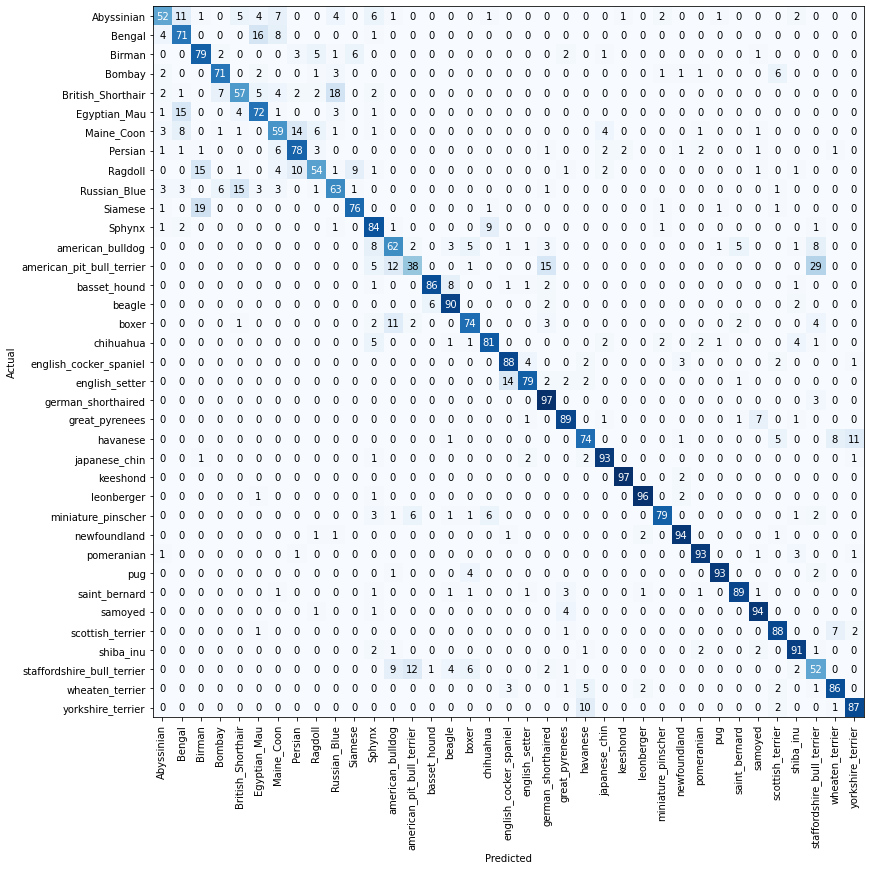

In [ ]:
cm = confusion_matrix(all_classes,predictions)
make_fig_cm(cm)

## Well done!

What would you do to speed up the process in the last part?

In [ ]:
[![Dataflowr](https://raw.githubusercontent.com/dataflowr/website/master/_assets/dataflowr_logo.png)](https://dataflowr.github.io/website/)